# Inverse Estimation of $\kappa$ Using PINNs

This notebook uses Physics-Informed Neural Networks (PINNs) to solve an inverse problem in which the stiffness parameter $\kappa$ in a frictional system is unknown and is estimated during training. The governing nondimensionalized ODE system is:

\begin{align*}
\frac{d\tilde{u}}{d\tilde{t}} &= \tilde{v}, \\
\frac{d\tilde{v}}{d\tilde{t}} &= \kappa\big(v_0 \tilde{t} - \tilde{u}\big) - \alpha \Big( f_0 + a \ln \tilde{v} + b \ln \tilde{\theta} \Big), \\
\frac{d\tilde{\theta}}{d\tilde{t}} &= -\tilde{v}\tilde{\theta}\ln\big(\tilde{v}\tilde{\theta}\big).
\end{align*}

In this inverse problem, the friction parameters $f_0$, $a$, and $b$ are assumed known, while $\kappa$ is treated as a trainable variable. The loss function combines:

- **Residual loss ($\text{MSE}_R$)**: Enforcing that the network output satisfies the ODE system.
- **Boundary loss ($\text{MSE}_B$)**: Ensuring the initial conditions are met.
- **Measurement loss ($\text{MSE}_m$)**: Penalizing the difference between the network output and measured data.

Below, each step is described in detail.

## Import Libraries

We begin by importing the required libraries: DeepXDE (for PINNs), NumPy, Matplotlib, Pandas, and the backend (TensorFlow) from DeepXDE.

In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate
from deepxde.backend import tf
import os

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



## Dataset Variables Explanation

The dataset (stored in a CSV file) contains the following columns:

- **`Var1`**: Time (in seconds, ranging from 0 to 100).
- **`y1_1`**: $\tilde{u}$ (slip) – the displacement in the spring-block slider model.
- **`y1_2`**: $\tilde{v}$ (slip rate) – the time derivative of the slip (velocity).
- **`y1_3`**: $\theta$ (state variable) – a variable describing the frictional state.

These measured values (denoted $u^*$, $v^*$, and $\theta^*$) will be used in the measurement loss term.

In [2]:
# Read the dataset (using the first 10,000 data points)
raw = pd.read_csv('../Dataset/sbm1.csv')
raw = raw[0:10000]

# Extract the columns
observe_t = raw['Var1']
u_ext = raw['y1_1']
v_ext = raw['y1_2']
theta_ext = raw['y1_3']

## Interpolate and Plot Measurements

We interpolate the data to obtain **25 equidistant measurement points** between time 0 and 100. These points will be used to enforce the measurement loss.

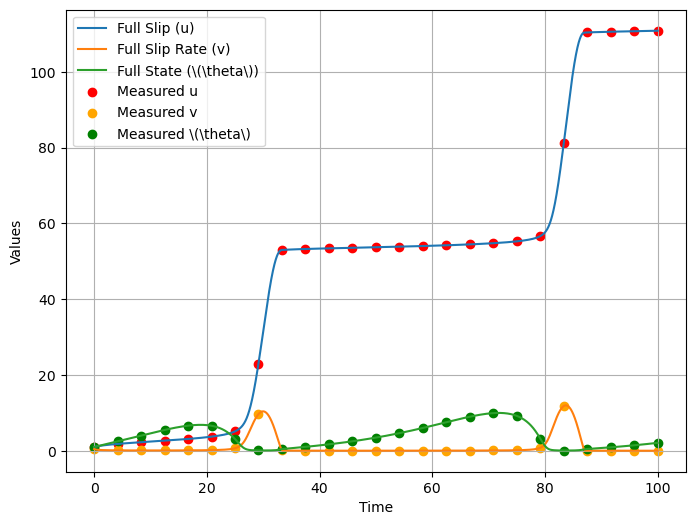

In [3]:
t_int = np.linspace(0, 100, 25)

u_int = np.interp(t_int, observe_t.values.reshape(-1), u_ext.values.reshape(-1))
v_int = np.interp(t_int, observe_t.values.reshape(-1), v_ext.values.reshape(-1))
theta_int = np.interp(t_int, observe_t.values.reshape(-1), theta_ext.values.reshape(-1))

plt.figure(figsize=(8,6))
plt.plot(observe_t, u_ext, label="Full Slip (u)")
plt.plot(observe_t, v_ext, label="Full Slip Rate (v)")
plt.plot(observe_t, theta_ext, label=r"Full State (\(\theta\))")

plt.scatter(t_int, u_int, color='red', label="Measured u")
plt.scatter(t_int, v_int, color='orange', label="Measured v")
plt.scatter(t_int, theta_int, color='green', label=r"Measured \(\theta\)")

plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

# Reshape the data for DeepXDE
observe_t = t_int.reshape((-1, 1))
u_ext = u_int.reshape((-1, 1))
v_ext = v_int.reshape((-1, 1))
theta_ext = theta_int.reshape((-1, 1))

## Define Measurement Boundary Conditions

We enforce the measured data by creating boundary conditions at the 25 measurement points using DeepXDE’s `PointSetBC` for each variable.

In [4]:
observe_y0 = dde.icbc.PointSetBC(observe_t, u_ext, component=0)
observe_y1 = dde.icbc.PointSetBC(observe_t, v_ext, component=1)
observe_y2 = dde.icbc.PointSetBC(observe_t, theta_ext, component=2)

## Inverse Problem Formulation: Inferring $\kappa$

In this inverse problem, the stiffness parameter $\kappa$ is unknown. The other parameters ($\alpha$, $v_0$, $f_0$, $a$, and $b$) are assumed known. 

The governing ODE system is:

\begin{align*}
\frac{d\tilde{u}}{d\tilde{t}} &= \tilde{v}, \\
\frac{d\tilde{v}}{d\tilde{t}} &= \kappa\big(v_0 \tilde{t} - \tilde{u}\big) - \alpha \Big( f_0 + a \ln \tilde{v} + b \ln \tilde{\theta} \Big), \\
\frac{d\tilde{\theta}}{d\tilde{t}} &= -\tilde{v}\tilde{\theta}\ln\big(\tilde{v}\tilde{\theta}\big).
\end{align*}

Here, $\kappa$ is modeled as a trainable variable (with an initial guess), and its value will be updated during training.

In [5]:
def inverse_ode_system_kappa(x, y):
    """
    Defines the residuals of the ODE system for the inverse problem where
    the stiffness parameter \(\kappa\) is unknown and treated as a trainable variable.
    """
    # Split y into its components: u, v, and theta
    u = y[:, 0:1]
    v = y[:, 1:2]
    theta = y[:, 2:3]

    # Compute the time derivatives using automatic differentiation
    du_t = dde.grad.jacobian(y, x, i=0)
    dv_t = dde.grad.jacobian(y, x, i=1)
    dtheta_t = dde.grad.jacobian(y, x, i=2)

    # Known parameters
    alpha = 9.81
    v0 = 1
    f0 = 0.2
    a = 0.2
    b = 0.3

    # Treat kappa as a trainable variable (initialize with a guess, e.g., 0.25)
    kappa_inv = dde.Variable(0.25)

    # Clip v and theta to ensure positive arguments in logarithms
    v_clip = tf.clip_by_value(v, 1e-6, 13)
    theta_clip = tf.clip_by_value(theta, 1e-6, 11)

    # Define the residuals of the ODE system
    res_u = du_t - v_clip
    res_v = dv_t - (kappa_inv * (v0 * x - u) - alpha * (f0 + a * tf.math.log(v_clip) + b * tf.math.log(theta_clip)))
    res_theta = dtheta_t + v_clip * theta_clip * tf.math.log(v_clip * theta_clip)

    return [res_u, res_v, res_theta]

## Compile and Train the PINN Model

The following steps are performed:

- **Geometry**: The time domain is set as \([0, 100]\).
- **Data**: We enforce that the network satisfies the inverse ODE system and that its predictions match the 25 measurement points (using 20,000 residual points).
- **Network Architecture**: A feed-forward neural network (FNN) with 6 hidden layers of 64 neurons each is used. The network takes time as input and outputs three values: \(\tilde{u}\), \(\tilde{v}\), and \(\tilde{\theta}\).
- **Output Transform**: An output transform is applied to help the network meet the initial conditions.
- **Training**: The model is compiled with the Adam optimizer (learning rate = 0.0001) and trained for 50,000 iterations.

During training, the trainable variable \(\kappa\) is updated along with the network parameters to minimize the total loss.

In [ ]:
geom = dde.geometry.TimeDomain(0, 100)

data = dde.data.PDE(
    geom,
    inverse_ode_system_kappa,
    [observe_y0, observe_y1, observe_y2],
    20000,
    0,
    num_test=3000
)

In [ ]:
layer_size = [1] + [64] * 6 + [3]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

In [ ]:
def output_transform(t, y):
    """
    Output transform to help the network satisfy initial conditions.
    We shift the outputs as follows:
      - \(u \approx \tanh(t)\,y_1 + 1\)
      - \(v \approx \tanh(t)\,y_2 + 0.5\)
      - \(\theta \approx \tanh(t)\,y_3 + 1\)
    """
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    y3 = y[:, 2:3]
    return tf.concat([
        y1 * tf.tanh(t) + 1,
        y2 * tf.tanh(t) + 0.5,
        y3 * tf.tanh(t) + 1
    ], axis=1)

net.apply_output_transform(output_transform)

In [ ]:
model = dde.Model(data, net)
model.compile(
    "adam",
    lr=0.0001,
    loss_weights=[1, 1, 1, 1, 1, 1]
)

# Create output directory for saving checkpoints
path = "./../output/Model/model"
os.makedirs(path, exist_ok=True)
checkpoint_path = os.path.join(path, "model.ckpt")
checker = dde.callbacks.ModelCheckpoint(
      checkpoint_path, save_better_only=True, period=50
  )

# Train the model for 50,000 iterations 
losshistory, train_state = model.train(epochs=50000, callbacks=[checker])

## Prediction and Plotting

After training the PINN, we predict the solution over the full time domain and compare the predicted curves with the true measured data. 

This visualization helps assess the accuracy of the inverse model and the inferred $\kappa$ value.

In [ ]:
observe_t = raw['Var1']
u_ext = raw['y1_1']
v_ext = raw['y1_2']
theta_ext = raw['y1_3']

plt.figure(figsize=(8,6))
plt.xlabel("Time")
plt.ylabel("y")

plt.plot(observe_t, u_ext, color="black", label="True u")
plt.plot(observe_t, v_ext, color="blue", label="True v")
plt.plot(observe_t, theta_ext, color="brown", label=r'True $\theta$')

t = np.linspace(0, 100, 10000).reshape((-1, 1))
sol_pred = model.predict(t)
u_pred = sol_pred[:, 0:1]
v_pred = sol_pred[:, 1:2]
theta_pred = sol_pred[:, 2:3]

plt.plot(t, u_pred, color="red", linestyle="dashed", label="Predicted u")
plt.plot(t, v_pred, color="orange", linestyle="dashed", label="Predicted v")
plt.plot(t, theta_pred, color="green", linestyle="dashed", label=r"Predicted $\theta$")
plt.legend()
plt.grid(True)
plt.savefig('./../output/pred_inverse_kappa.png')
plt.show()